## Modello di riferimento: Naive Bayes per la classificazione dei ticket

In questo notebook viene analizzato un modello di classificazione testuale basato su **Multinomial Naive Bayes**, utilizzato come termine di confronto concettuale rispetto ad altri approcci lineari applicati allo stesso problema.

Il modello viene confrontato con:
- una pipeline **TF-IDF + Logistic Regression**, adottata come baseline,
- una pipeline **TF-IDF + Support Vector Machine lineare**, considerata come alternativa metodologica.

### Obiettivi della sperimentazione

Gli obiettivi di questa analisi sono i seguenti:
- valutare le prestazioni di **Multinomial Naive Bayes** nei due task di classificazione:
  - assegnazione della **categoria** (Amministrazione, Commerciale, Tecnico),
  - stima della **priorità** (bassa, media, alta);
- utilizzare la medesima rappresentazione testuale basata su **TF-IDF**, al fine di garantire coerenza metodologica nel confronto tra i modelli;
- analizzare i limiti strutturali del modello Naive Bayes rispetto agli approcci lineari discriminativi


In [1]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

# Opzionale: stile grafico più leggibile
sns.set(style="whitegrid")

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Caricamento del dataset preprocessato

Utilizzo dello stesso dataset già pulito impiegato per Logistic Regression e SVM.

Struttura attesa del file:
- `text_clean`: testo preprocessato (minuscole, punteggiatura rimossa, ecc.)
- `category`: etichetta di categoria
- `priority`: etichetta di priorità
- `split`: indica se il record appartiene a **train** o **test**

In [2]:
DATA_PATH = DATA_DIR / "splits" / "tickets_preprocessed_split.csv"

df = pd.read_csv(DATA_PATH)

df.head()

,id,title,body,category,priority,title_length,body_length,text,text_clean,len_words_raw,len_words_clean,split
0,1,NaN,Mancato allineamento incassi: il boinfico di 4...,Amministrazione,media,0,319,Mancato allineamento incassi: il boinfico di 4...,mancato allineamento incassi il boinfico di 44...,49,50,train
1,2,NaN,Richiesta estrazione dati statistici su utiliz...,Amministrazione,bassa,0,254,Richiesta estrazione dati statistici su utiliz...,richiesta estrazione dati statistici su utiliz...,34,34,test
2,3,NaN,Duplicazione righe in visualizzazione estratto...,Amministrazione,alta,0,333,Duplicazione righe in visualizzazione estratto...,duplicazione righe in visualizzazione estratto...,49,49,train
3,4,NaN,Procedura di backup storico: export fatture an...,Amministrazione,media,0,292,Procedura di backup storico: export fatture an...,procedura di backup storico export fatture ann...,45,45,train
4,5,NaN,Duplicazione righe in visualizzazione estratto...,Amministrazione,bassa,0,260,Duplicazione righe in visualizzazione estratto...,duplicazione righe in visualizzazione estratto...,39,40,train


In [3]:
# Verifica della colonna 'split'
df["split"].value_counts()


split
train    384
test      96
Name: count, dtype: int64

## Costruzione dei set di training e test

Come per gli altri modelli:
- input testuale: `text_clean`
- target:
  - `category` per il modello di categoria
  - `priority` per il modello di priorità
- split predefinito dal campo `split`.


In [4]:
# Feature testuale
X_train = df[df["split"] == "train"]["text_clean"]
X_test  = df[df["split"] == "test"]["text_clean"]

# Target per categoria
y_train_cat = df[df["split"] == "train"]["category"]
y_test_cat  = df[df["split"] == "test"]["category"]

# Target per priorità
y_train_prio = df[df["split"] == "train"]["priority"]
y_test_prio  = df[df["split"] == "test"]["priority"]

print("Dimensioni training:", X_train.shape[0])
print("Dimensioni test:", X_test.shape[0])

Dimensioni training: 384
Dimensioni test: 96


In [5]:
print("Distribuzione categoria - train:")
print(y_train_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione categoria - test:")
print(y_test_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - train:")
print(y_train_prio.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - test:")
print(y_test_prio.value_counts(normalize=True).round(3))


Distribuzione categoria - train:
category
Tecnico            0.451
Amministrazione    0.299
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione categoria - test:
category
Tecnico            0.448
Amministrazione    0.302
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione priorità - train:
priority
media    0.440
bassa    0.284
alta     0.276
Name: proportion, dtype: float64

Distribuzione priorità - test:
priority
media    0.448
bassa    0.312
alta     0.240
Name: proportion, dtype: float64


## Modello Naive Bayes per la classificazione della categoria

In questa sezione viene implementato un modello di classificazione basato su **Multinomial Naive Bayes**, applicato al task di assegnazione della categoria dei ticket.

La rappresentazione testuale è ottenuta mediante **TF-IDF**, al fine di mantenere coerenza metodologica con le pipeline precedentemente analizzate basate su Logistic Regression e Support Vector Machine lineare.

### Nota metodologica

In letteratura, il modello Naive Bayes viene frequentemente applicato a rappresentazioni basate su **conteggi grezzi** dei termini (ad esempio tramite *CountVectorizer*).  
In questo lavoro, l’uso di **TF-IDF** è deliberato e motivato dall’esigenza di garantire un confronto diretto tra modelli che condividono la stessa rappresentazione delle feature testuali.  

In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)
        
    # minuscole (e togli lowercase=False dal TFIDF)
    text = text.lower()
    
    # rimuovi solo simboli non utili
    text = re.sub(r"[^\w\sàèéìòù]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
pipe_cat_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"
    )),
    ("clf", MultinomialNB(
        alpha=1.0  # smoothing di Laplace standard
    ))
])

pipe_cat_nb


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001D1F810DC60>
,tokenizer,None


In [8]:
pipe_cat_nb.fit(X_train, y_train_cat)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001D1F810DC60>
,tokenizer,None


### Valutazione del modello Naive Bayes per categoria

Metriche:
- **Accuracy**
- **F1 macro**
- **Classification report**
- **Matrice di confusione**


In [9]:
y_pred_cat_nb = pipe_cat_nb.predict(X_test)

acc_cat_nb = accuracy_score(y_test_cat, y_pred_cat_nb)
f1_cat_nb = f1_score(y_test_cat, y_pred_cat_nb, average="macro")

print(f"Accuracy Naive Bayes (categoria): {acc_cat_nb:.3f}")
print(f"F1 macro Naive Bayes (categoria): {f1_cat_nb:.3f}")

print("\nClassification report Naive Bayes (categoria):")
print(classification_report(y_test_cat, y_pred_cat_nb))


Accuracy Naive Bayes (categoria): 0.802
F1 macro Naive Bayes (categoria): 0.782

Classification report Naive Bayes (categoria):
                 precision    recall  f1-score   support

Amministrazione       0.77      0.69      0.73        29
    Commerciale       0.77      0.71      0.74        24
        Tecnico       0.83      0.93      0.88        43

       accuracy                           0.80        96
      macro avg       0.79      0.78      0.78        96
   weighted avg       0.80      0.80      0.80        96



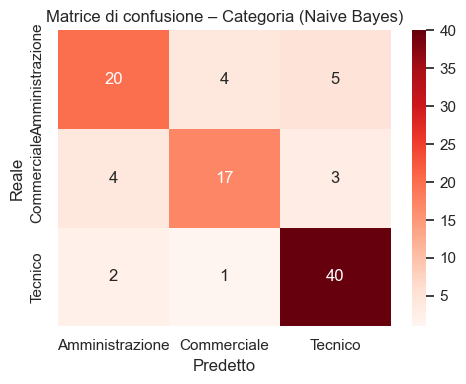

,Amministrazione,Commerciale,Tecnico
Amministrazione,20,4,5
Commerciale,4,17,3
Tecnico,2,1,40


In [10]:
labels_cat = sorted(y_train_cat.unique())

cm_cat_nb = confusion_matrix(y_test_cat, y_pred_cat_nb, labels=labels_cat)
cm_cat_nb_df = pd.DataFrame(cm_cat_nb, index=labels_cat, columns=labels_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cat_nb_df, annot=True, fmt="d", cmap="Reds")
plt.title("Matrice di confusione – Categoria (Naive Bayes)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_cat_nb_df


## Modello Naive Bayes per la classificazione di **priorità**

Si applica la stessa pipeline:

- TF-IDF come rappresentazione del testo
- Multinomial Naive Bayes come classificatore


In [11]:
pipe_prio_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        strip_accents="unicode"
    )),
    ("clf", MultinomialNB(
        alpha=1.0
    ))
])

pipe_prio_nb


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001D1F810DC60>
,tokenizer,None


In [12]:
pipe_prio_nb.fit(X_train, y_train_prio)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...001D1F810DC60>
,tokenizer,None


### Valutazione del modello Naive Bayes per priorità

Stesse metriche:
- **Accuracy**
- **F1 macro**
- **Classification report**
- **Matrice di confusione**


In [13]:
y_pred_prio_nb = pipe_prio_nb.predict(X_test)

acc_prio_nb = accuracy_score(y_test_prio, y_pred_prio_nb)
f1_prio_nb = f1_score(y_test_prio, y_pred_prio_nb, average="macro")

print(f"Accuracy Naive Bayes (priorità): {acc_prio_nb:.3f}")
print(f"F1 macro Naive Bayes (priorità): {f1_prio_nb:.3f}")

print("\nClassification report Naive Bayes (priorità):")
print(classification_report(y_test_prio, y_pred_prio_nb))


Accuracy Naive Bayes (priorità): 0.833
F1 macro Naive Bayes (priorità): 0.830

Classification report Naive Bayes (priorità):
              precision    recall  f1-score   support

        alta       0.89      0.74      0.81        23
       bassa       0.81      0.87      0.84        30
       media       0.82      0.86      0.84        43

    accuracy                           0.83        96
   macro avg       0.84      0.82      0.83        96
weighted avg       0.84      0.83      0.83        96



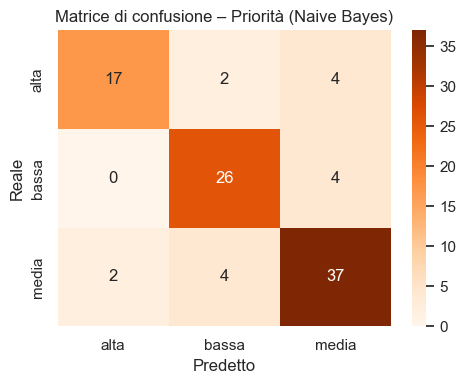

,alta,bassa,media
alta,17,2,4
bassa,0,26,4
media,2,4,37


In [14]:
labels_prio = sorted(y_train_prio.unique())

cm_prio_nb = confusion_matrix(y_test_prio, y_pred_prio_nb, labels=labels_prio)
cm_prio_nb_df = pd.DataFrame(cm_prio_nb, index=labels_prio, columns=labels_prio)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_prio_nb_df, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice di confusione – Priorità (Naive Bayes)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_prio_nb_df


In [15]:
results_nb = {
    "categoria_accuracy": acc_cat_nb,
    "categoria_f1": f1_cat_nb,
    "priorita_accuracy": acc_prio_nb,
    "priorita_f1": f1_prio_nb
}

import json
with open(DATA_DIR / "results_baseline" / "results_nb.json", "w") as f:
    json.dump(results_nb, f)

In [16]:
import json

results_nb = {
    "categoria_accuracy": float(acc_cat_nb),
    "categoria_f1_macro": float(f1_cat_nb),
    "priorita_accuracy": float(acc_prio_nb),
    "priorita_f1_macro": float(f1_prio_nb)
}

with open(DATA_DIR / "results_baseline" / "nb_metrics.json", "w") as f:
    json.dump(results_nb, f, indent=4)

In [17]:
cm_cat_nb_df.to_csv(DATA_DIR / "results_baseline" / "confusion_cat_nb.csv", index=True)
cm_prio_nb_df.to_csv(DATA_DIR / "results_baseline" / "confusion_prio_nb.csv", index=True)

In [18]:
import numpy as np

pipe_cat_nb.fit(X_train, y_train_cat)

vectorizer = pipe_cat_nb.named_steps["tfidf"]
clf = pipe_cat_nb.named_steps["clf"]

feature_names = np.array(vectorizer.get_feature_names_out())
log_prob = clf.feature_log_prob_

top_k = 10
for i, category in enumerate(clf.classes_):
    other_idx = [j for j in range(len(clf.classes_)) if j != i]
    score = log_prob[i] - log_prob[other_idx].mean(axis=0)

    top_idx = np.argsort(score)[-top_k:][::-1]
    top_terms = feature_names[top_idx]

    print(f"\n{'='*60}")
    print(f"Top keywords discriminanti per {category}:")
    print(f"{'='*60}")
    for term in top_terms:
        print(f"  - {term}")



Top keywords discriminanti per Amministrazione:
  - video
  - risulta
  - fatture
  - export
  - salvataggio
  - account
  - validazione
  - nuovo cliente
  - pulizia
  - segna

Top keywords discriminanti per Commerciale:
  - offerta
  - crm
  - 500
  - contatti
  - invio
  - completare
  - opportunità
  - commerciale
  - linea
  - senza



Top keywords discriminanti per Tecnico:
  - valutare
  - test
  - patch
  - indice
  - obsoleta
  - specifica
  - commerciali
  - tenta
  - quando tenta
  - scan


In [19]:
import numpy as np

# Fit del modello NB per la priorità
pipe_prio_nb.fit(X_train, y_train_prio)

# Estrai vectorizer e classificatore
vectorizer = pipe_prio_nb.named_steps["tfidf"]
clf = pipe_prio_nb.named_steps["clf"]

# Nomi delle feature
feature_names = np.array(vectorizer.get_feature_names_out())

# Matrice log P(feature | classe)
log_prob = clf.feature_log_prob_

top_k = 10

for i, label in enumerate(clf.classes_):
    other_idx = [j for j in range(len(clf.classes_)) if j != i]

    # Punteggio discriminante: quanto la feature è più tipica di questa classe
    score = log_prob[i] - log_prob[other_idx].mean(axis=0)

    top_idx = np.argsort(score)[-top_k:][::-1]
    top_terms = feature_names[top_idx]

    print(f"\n{'='*60}")
    print(f"Top keywords discriminanti per priorità = {label}:")
    print(f"{'='*60}")
    for term, s in zip(feature_names[top_idx], score[top_idx]):
        print(f"  - {term:25s}  score={s:.3f}")


Top keywords discriminanti per priorità = alta:
  - critico                    score=2.289
  - bloccato                   score=1.997
  - urgente                    score=1.976
  - ordine                     score=1.922
  - errore critico             score=1.811
  - accedere                   score=1.799
  - ripristino                 score=1.684
  - immediato                  score=1.587
  - confermare                 score=1.584
  - tenta                      score=1.580

Top keywords discriminanti per priorità = bassa:
  - lungo                      score=2.021
  - patch                      score=1.975
  - studio                     score=1.943
  - obsoleta                   score=1.885
  - entry                      score=1.632
  - data entry                 score=1.632
  - prossimo                   score=1.603
  - pianificare                score=1.533
  - manutenzione               score=1.463
  - attività                   score=1.455

Top keywords discriminanti per priorità 